<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/Variational%20Auto-Encoder%20for%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#just mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [81]:
# Creating dataset

from pathlib import Path
import random
import numpy as np

#!!!!!!!!!!change to wherever MNIST data is located
data_folder = Path("/content/gdrive/My Drive/ESE546_2019/HW1")

import torch
from torchvision import datasets, transforms

torch.manual_seed(0)

transform = transforms.Compose(
        [transforms.Resize((14,14)),
         transforms.ToTensor()])

# trainset = datasets.MNIST(data_folder / "MNIST_data/", download=True, train=True, transform=transform)
# valset = datasets.MNIST(data_folder / "MNIST_data/", download=True, train=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# testloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

trainset = datasets.MNIST(data_folder / "MNIST_data/", download=True, train=True)
sampled_dataset = []
label_count = 2000*np.ones(10,dtype=np.int32)
for image,label in trainset:
  image = transform(image)
  image[image>0.5] = 1
  image[image<=0.5] = 0
  if label_count[label]>0:
    label_count[label] -= 1 
    sampled_dataset.append((image,label))

train_size = int(0.8 * len(sampled_dataset))
test_size = len(sampled_dataset) - train_size
trainset, testset = torch.utils.data.random_split(sampled_dataset, [train_size, test_size])
print(len(trainset),len(testset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
print(len(trainloader),len(testloader))

16000 4000
250 63


In [90]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, z_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.mu = nn.Linear(hidden_dim, z_dim)
    self.var = nn.Linear(hidden_dim, z_dim)
      
  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    z_mu = self.mu(x)
    z_var = self.var(x)
    return z_mu, z_var

class Decoder(nn.Module):
  def __init__(self, z_dim, hidden_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(z_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    predicted = torch.sigmoid(self.fc2(x))
    return predicted

class VAE(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec

  def forward(self, x):
    #encode
    z_mu, z_var = self.enc(x)
    
    #sample
    std = torch.exp(0.5 * z_var)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)

    # decode
    predicted = self.dec(x_sample)
    return predicted, z_mu, z_var


INPUT_DIM = 14 * 14 # size of each input
HIDDEN_DIM = 128    # hidden dimension
LATENT_DIM = 8     # latent vector dimension

encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
model = VAE(encoder, decoder).to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.01)

reconstruction_loss = []  
kl_divergence_loss = []
training_loss = []
validation_loss = []

def train():
  model.train()

  train_loss = 0

  for image, label in trainloader:
    image = image.to(device).view(-1,14*14)
    
    optimizer.zero_grad()

    image_sample, z_mu, z_var = model(image)
    
    # print(image_sample.shape, image.shape)

    recon_loss = F.binary_cross_entropy(image_sample, image, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + z_var - z_mu**2 - torch.exp(z_var))

    loss = recon_loss + kl_loss

    # print(loss.item(),recon_loss.item(),kl_loss.item())

    loss.backward()

    train_loss += loss.item()
    
    optimizer.step()

    reconstruction_loss.append(recon_loss)
    kl_divergence_loss.append(kl_loss)
    
  return train_loss/len(trainloader)

def test():
  model.eval()

  test_loss = 0
  
  with torch.no_grad():
    for image, label in testloader:
      image = image.to(device).view(-1,14*14)
    
      image_sample, z_mu, z_var = model(image)

      # print(image_sample.shape, image.shape)

      recon_loss = F.binary_cross_entropy(image_sample, image, reduction='sum')

      kl_loss = -0.5 * torch.sum(1 + z_var - z_mu**2 - torch.exp(z_var))

      loss = recon_loss + kl_loss

      # print(loss.item(),recon_loss.item(),kl_loss.item())
      
      test_loss += loss.item()

  return test_loss/len(testloader) 


VAE(
  (enc): Encoder(
    (fc1): Linear(in_features=196, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=8, bias=True)
    (var): Linear(in_features=128, out_features=8, bias=True)
  )
  (dec): Decoder(
    (fc1): Linear(in_features=8, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=196, bias=True)
  )
)


In [91]:
best_test_loss = float('inf')
epochs = 30

for e in range(epochs):

    train_loss = train()
    test_loss = test()

    training_loss.append(train_loss)
    validation_loss.append(test_loss)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    
    # if best_test_loss > test_loss:
    #     best_test_loss = test_loss
    #     patience_counter = 1
    # else:
    #     patience_counter += 1

    # if patience_counter > 3:
    #     break

Epoch 0, Train Loss: 2721.74, Test Loss: 2390.02
Epoch 1, Train Loss: 2360.74, Test Loss: 2288.91
Epoch 2, Train Loss: 2289.35, Test Loss: 2252.85
Epoch 3, Train Loss: 2253.18, Test Loss: 2220.78
Epoch 4, Train Loss: 2233.11, Test Loss: 2182.73
Epoch 5, Train Loss: 2211.09, Test Loss: 2183.62
Epoch 6, Train Loss: 2199.84, Test Loss: 2188.02
Epoch 7, Train Loss: 2191.50, Test Loss: 2180.86
Epoch 8, Train Loss: 2186.54, Test Loss: 2168.50
Epoch 9, Train Loss: 2176.13, Test Loss: 2166.16
Epoch 10, Train Loss: 2169.10, Test Loss: 2148.05
Epoch 11, Train Loss: 2170.64, Test Loss: 2175.04
Epoch 12, Train Loss: 2158.46, Test Loss: 2156.12
Epoch 13, Train Loss: 2154.46, Test Loss: 2146.04
Epoch 14, Train Loss: 2156.46, Test Loss: 2142.15
Epoch 15, Train Loss: 2144.79, Test Loss: 2135.53
Epoch 16, Train Loss: 2147.99, Test Loss: 2131.59
Epoch 17, Train Loss: 2135.60, Test Loss: 2125.98
Epoch 18, Train Loss: 2139.13, Test Loss: 2152.86
Epoch 19, Train Loss: 2138.44, Test Loss: 2130.81
Epoch 20, 

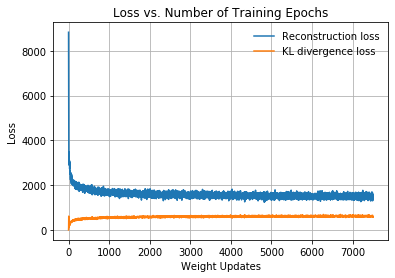

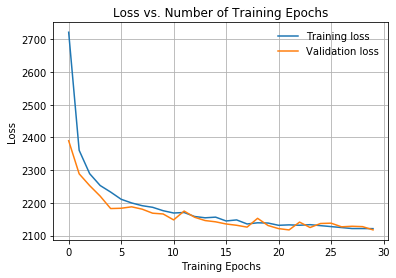

In [94]:
plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Weight Updates")
plt.ylabel("Loss")
plt.plot(reconstruction_loss, label='Reconstruction loss')
plt.plot(kl_divergence_loss, label='KL divergence loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

Q3.4 Test images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


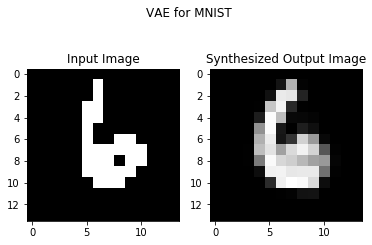

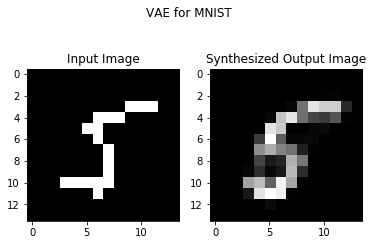

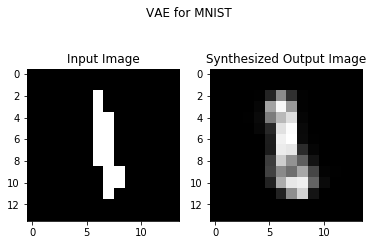

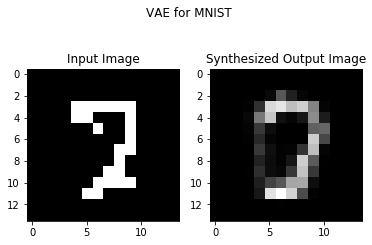

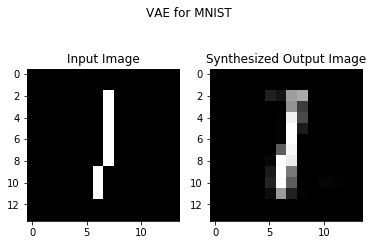

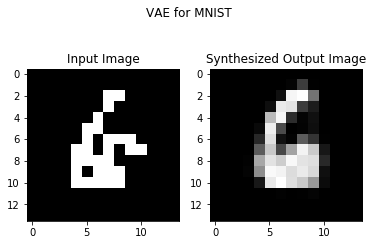

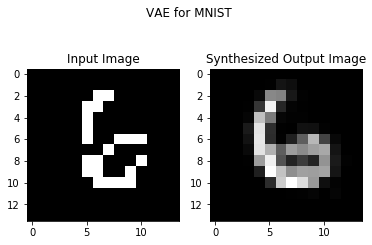

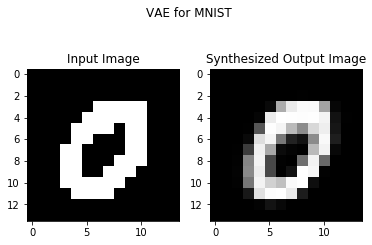

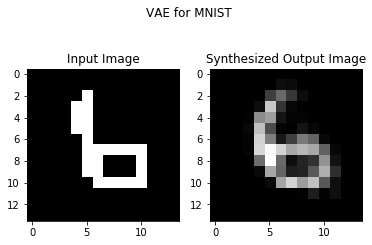

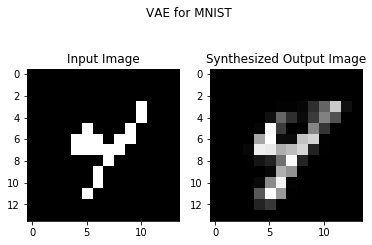

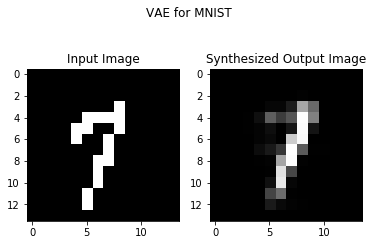

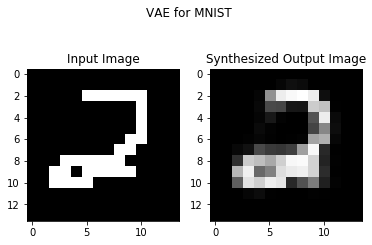

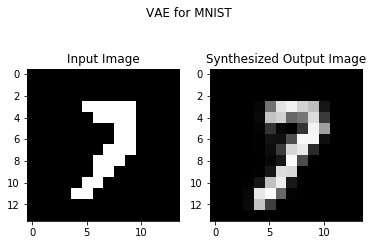

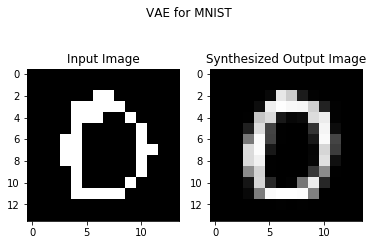

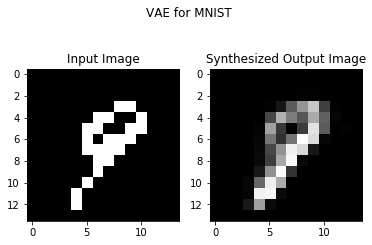

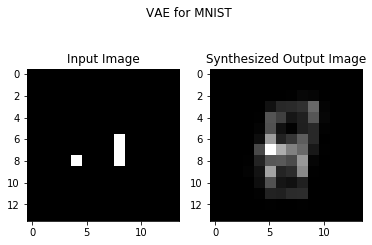

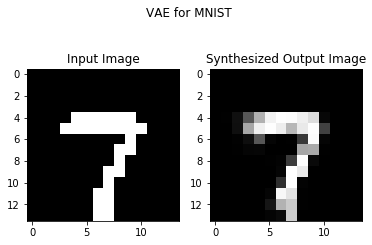

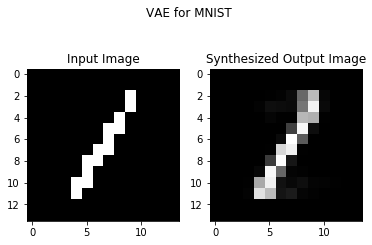

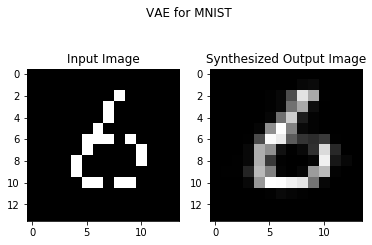

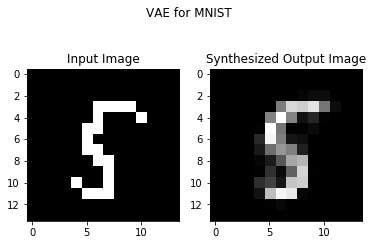

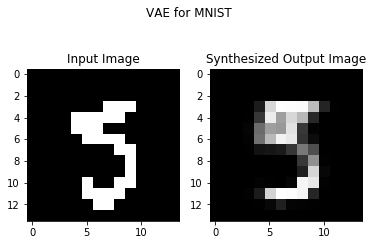

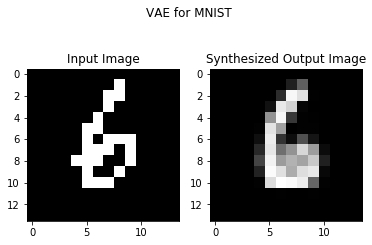

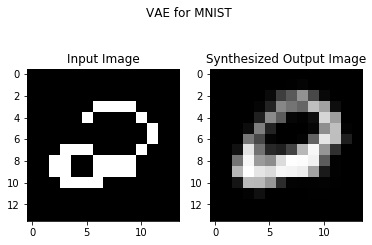

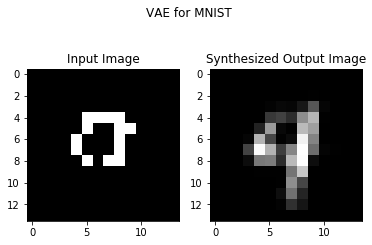

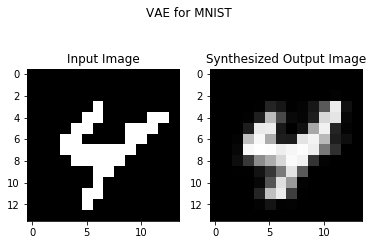

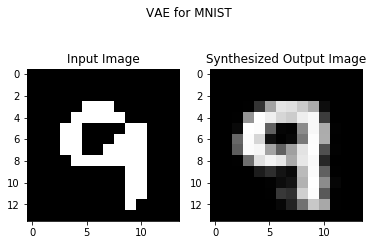

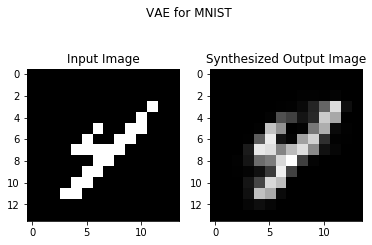

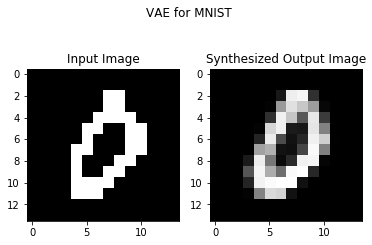

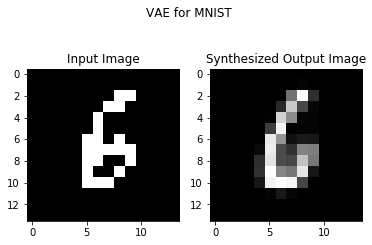

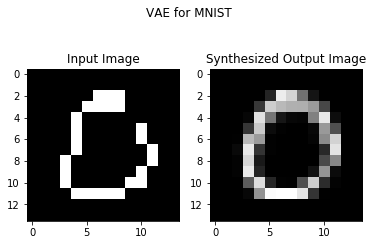

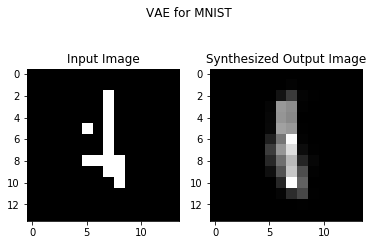

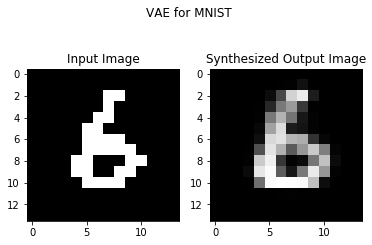

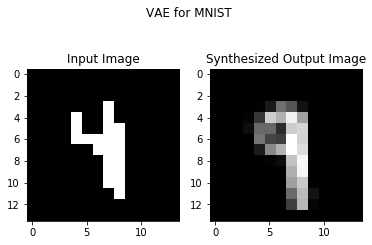

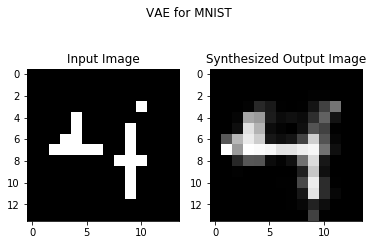

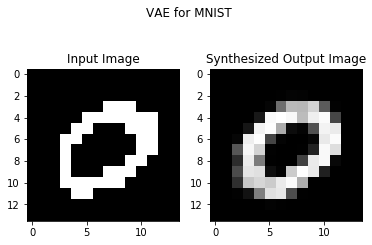

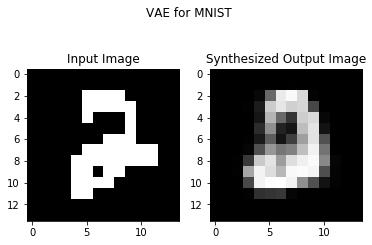

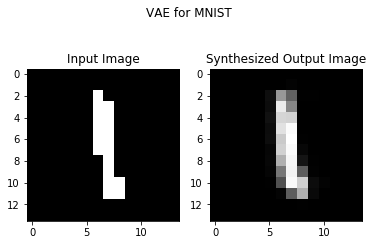

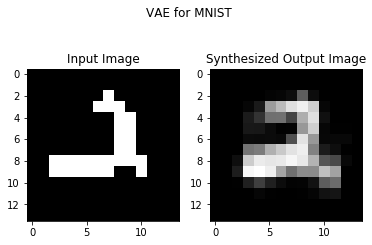

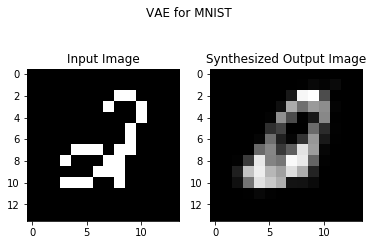

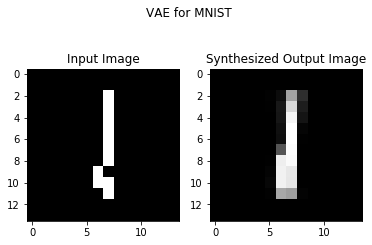

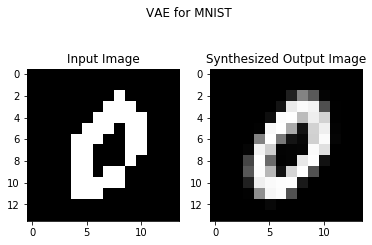

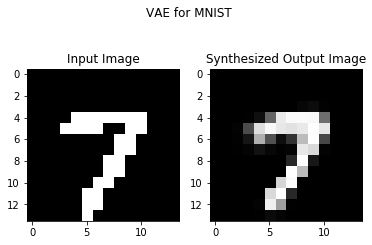

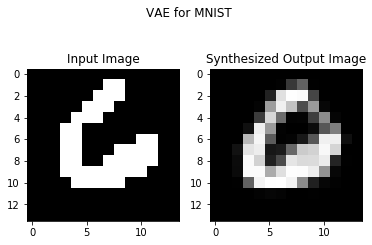

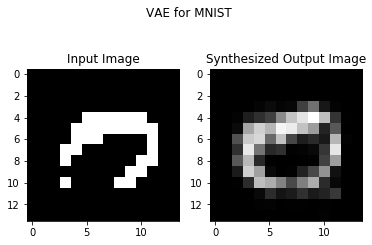

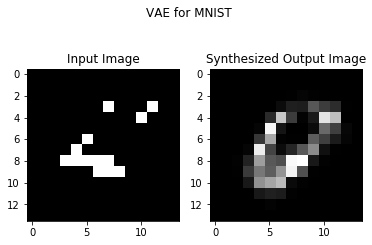

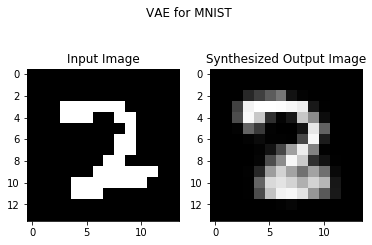

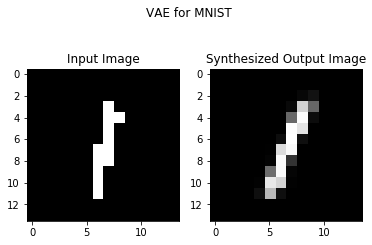

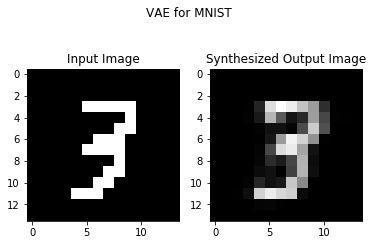

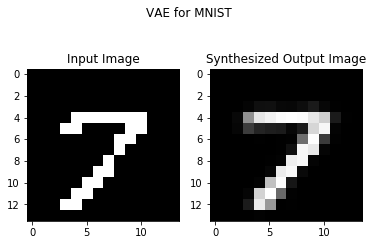

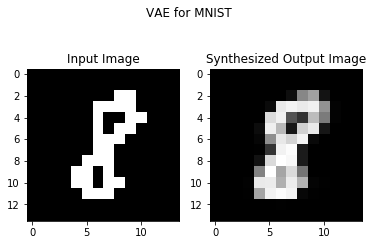

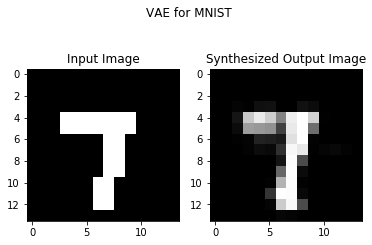

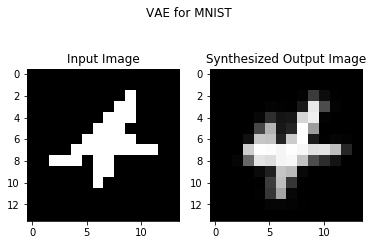

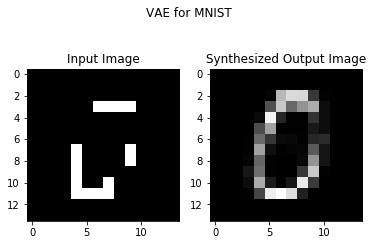

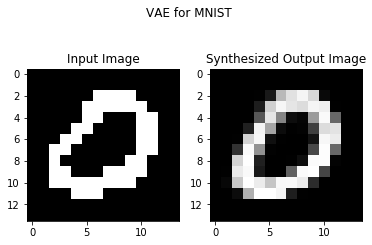

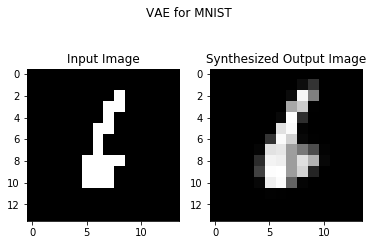

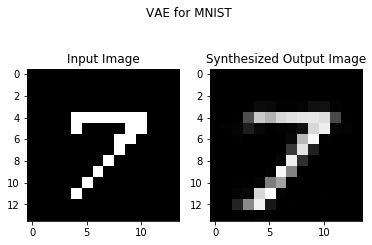

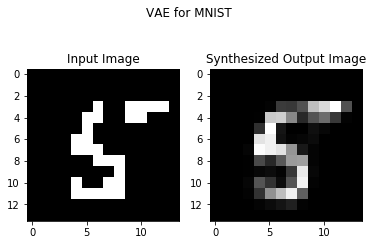

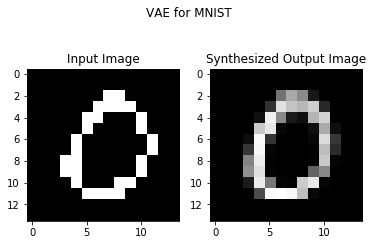

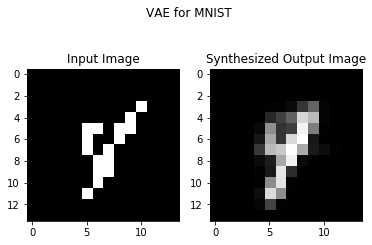

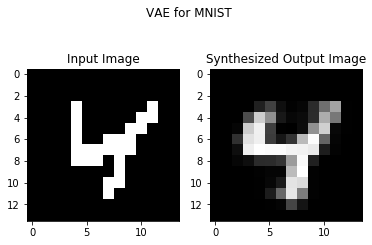

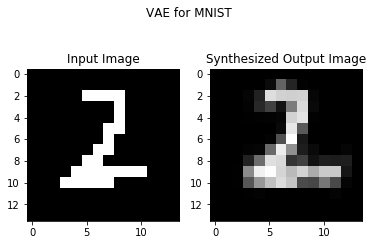

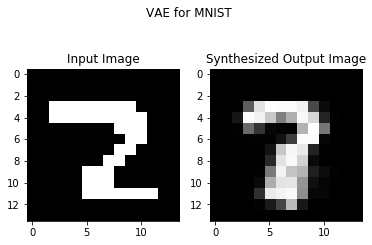

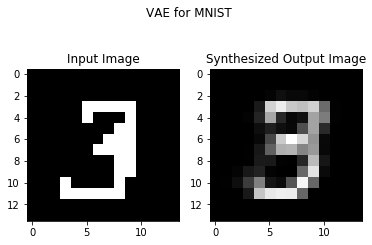

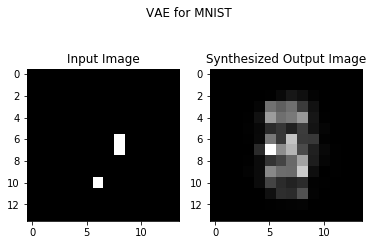

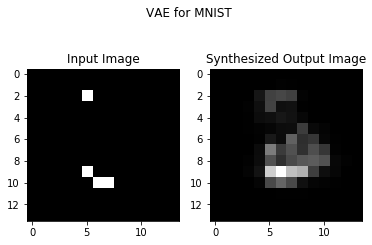

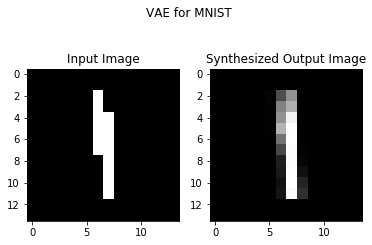

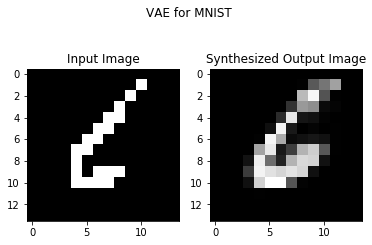

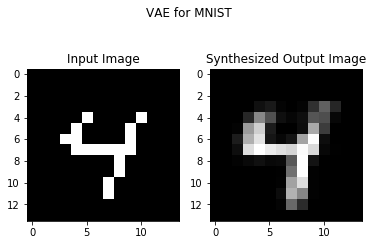

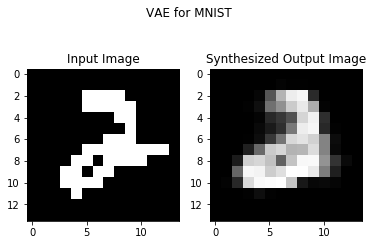

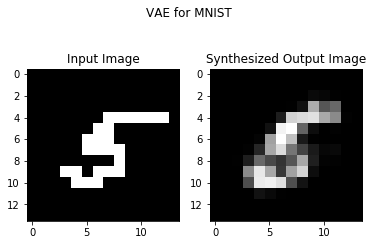

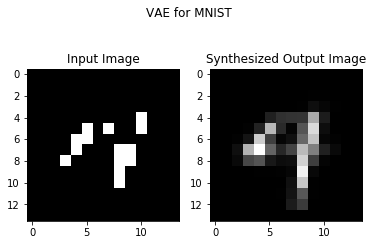

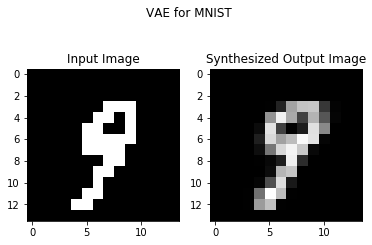

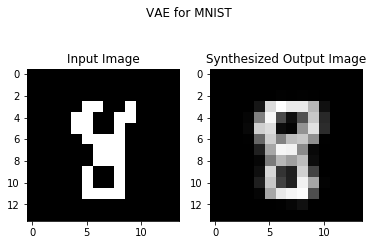

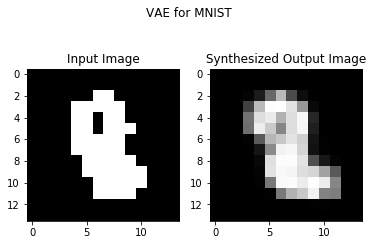

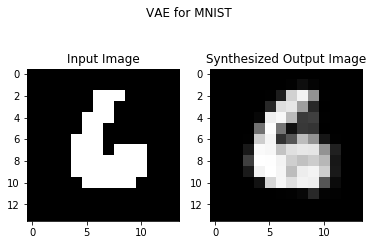

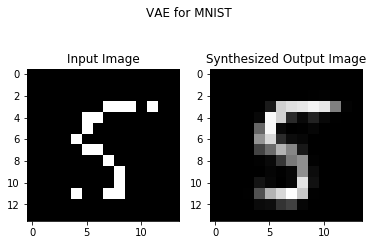

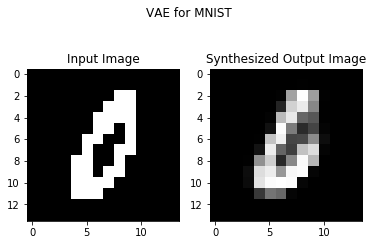

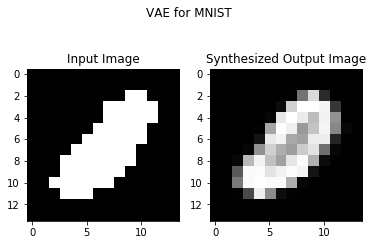

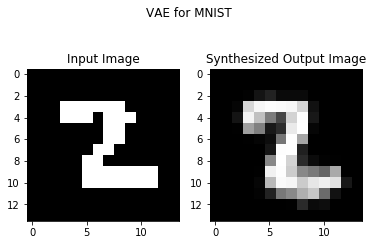

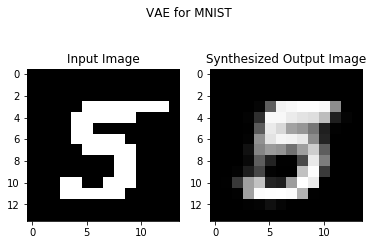

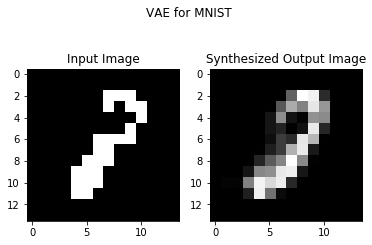

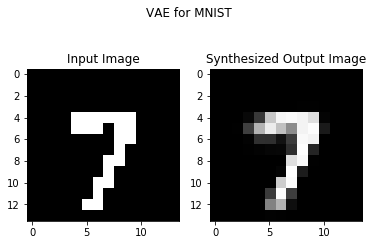

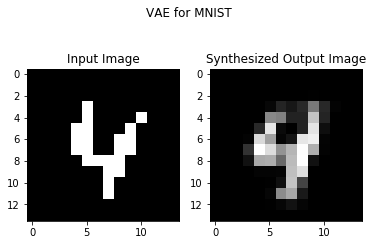

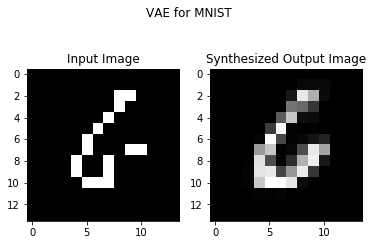

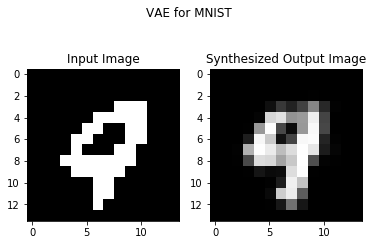

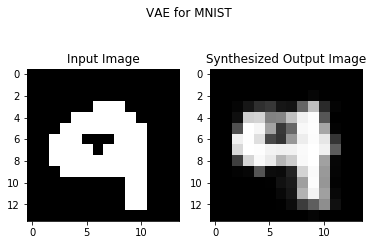

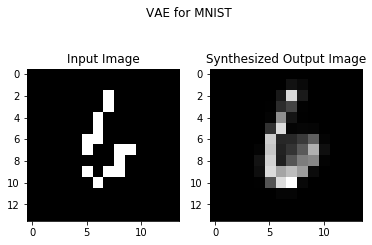

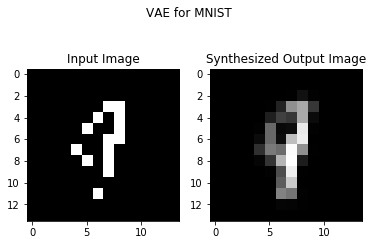

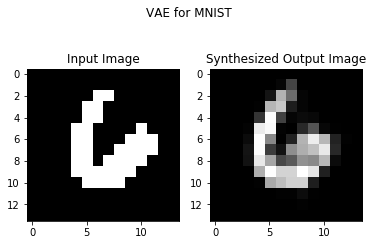

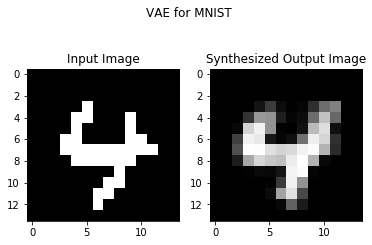

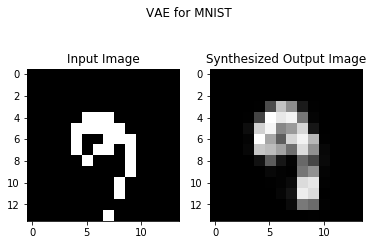

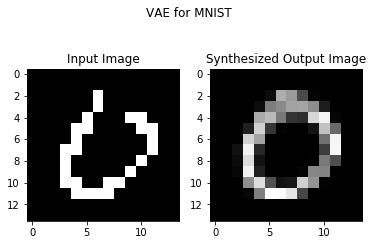

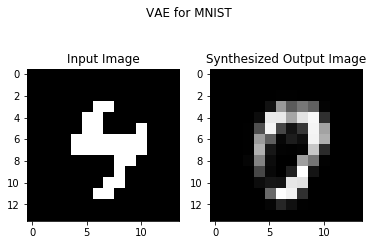

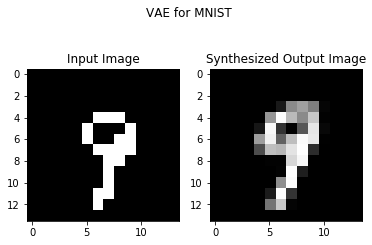

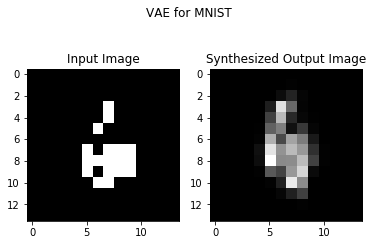

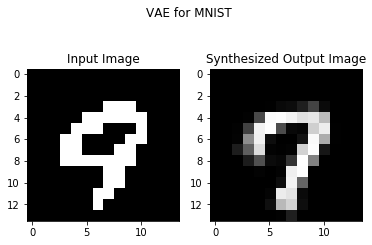

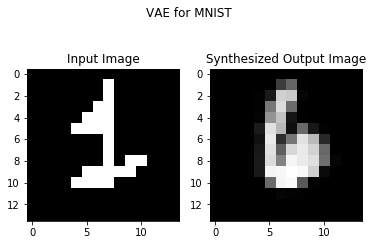

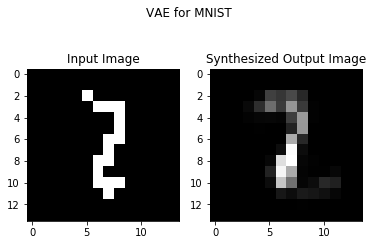

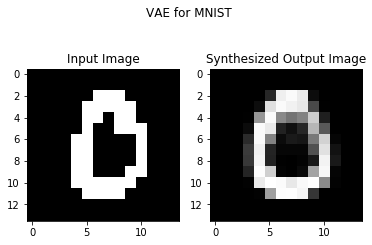

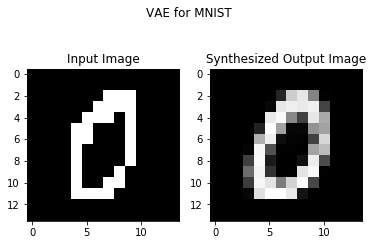

In [123]:
model.eval()

i = 0

with torch.no_grad():
  for image, label in testset:
    image = image.to(device).view(-1,14*14)
    recon_image, z_mu, z_var = model(image)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('VAE for MNIST')
    ax1.set_title('Input Image')
    ax2.set_title('Synthesized Output Image')
   
    ax1.imshow(image.view(14, 14).cpu(), cmap="gray")
    ax2.imshow(recon_image.data.view(14, 14).cpu(), cmap="gray")
    
    i += 1
    if i == 100:
      break
  

Q3.5 Sample from the generative model directly

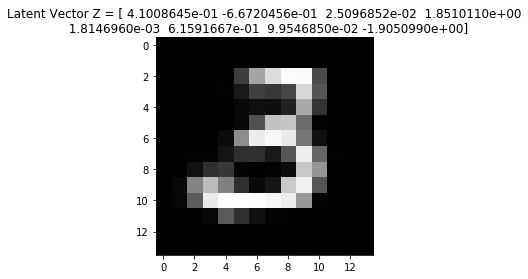

In [166]:
z = torch.randn(1, LATENT_DIM).to(device)
# print(z)
# run only the decoder
reconstructed_img = model.dec(z)
img = reconstructed_img.view(14, 14).data

# print(z.shape)
# print(img.shape)

plt.title('Latent Vector Z = {}'.format(z.cpu().squeeze().numpy()))
plt.imshow(img.cpu(), cmap='gray')